<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

Forest Emissions Tracking - Phase I
===================================

_by Joe Hamman and Jeremy Freeman (CarbonPlan)_

March 29, 2020

## Introduction
In general, greenhouse gasses (GHGs) arising from forest land use changes can be attributed to both natural factors (e.g. wildfire) and human activities (e.g. deforestation). Our approach is to build upon an existing body of research that has provided high-resolution satellite-based estimates of aboveground biomass (Spawn et al., 2020), forest cover change (Hansen et al., 2013), and change attribution (Curtis et al., 2018). While many of the necessary data products already exist, we can integrate, extend, or update these resources to provide global, current estimates that can be integrated with the other resources produced by the coalition.

Specifically, for any given spatial extent and time duration ($t1$ to $t2$), we can use three quantities — existing biomass, forest cover change, and change attribution — to estimate the effective GHG emissions from land use changes. The simplest estimate is:

$\Delta Biomass (t) = TotalBiomass (t) * \Delta ForestCover (\%)$

$Emissions (tCO_2) = \Delta Biomass (t) * 0.5 (tC/t) * 3.67 (tC02 / tC)$

where $\Delta ForestCover$ is the fraction of pixels within the given spatial extent that experienced a stand-replacement disturbance between $t1$ and $t2$. The $TotalBiomass$ is estimated as the aboveground biomass at time $t1$. This estimate can be further refined by attributing, for each pixel, the source of forest cover loss (e.g. wildfire, deforestation, etc.), and using those sources to express emissions fractionally and/or exclude certain categories from total estimates (e.g. rotational clear-cutting within tree plantations). Pixel-wise estimates can then be aggregated into province and country-wide estimates.

## Setup

To begin, we'll import a handful of Python libraries and set a few constants.

In [8]:
%matplotlib inline
# import dask
import intake
import xarray as xr
from tqdm import tqdm
import numcodecs
import numpy as np

TC02_PER_TC = 3.67
TC_PER_TBM = 0.5
SQM_PER_HA = 10000
ORNL_SCALING = 0.1

In [2]:
from dask_gateway import Gateway

gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = 2
options.worker_memory = 24
cluster = gateway.new_cluster(cluster_options=options)
cluster.adapt(minimum=1, maximum=300)
cluster


In [3]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-us-central1-b-prod-dask-gateway.prod:80/prod.5d7d8252679c43948430eccd292f57ac Dashboard: https://gcp-us-central1b.hub.carbonplan.org/services/dask-gateway/clusters/prod.5d7d8252679c43948430eccd292f57ac/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
# data catalog
cat = intake.open_catalog("https://raw.githubusercontent.com/carbonplan/forest-emissions-tracking/master/catalog.yaml")

In [5]:
import fsspec

with fsspec.open('https://storage.googleapis.com/earthenginepartners-hansen/GFC-2018-v1.6/treecover2000.txt') as f:
    lines = f.read().decode().splitlines() 
print(len(lines))
    
# americas tiles
lat_tags = ['80N', '70N', '60N', '50N', '40N', '30N', '20N', '10N', '00N',
             '10S', '20S', '30S', '40S', '50S']
lon_tags = [f'{n:03}W' for n in np.arange(10, 190, 10)] +\
            [f'{n:03}E' for n in np.arange(0, 190, 10)]

# all tiles
lats = []
lons = []
for line in lines:
    pieces = line.split('_')
    lat = pieces[-2]
    lon = pieces[-1].split('.')[0]
    
    if (lat in lat_tags) and (lon in lon_tags):
        lats.append(lat)
        lons.append(lon)
print(len(lats))

504
504


In [7]:
def _preprocess(da, lat=None, lon=None):
    da = da.rename({"x": "lon", "y": "lat"}).squeeze(drop=True)
    if lat is not None:
        da = da.assign_coords(lat=lat, lon=lon)
    return da


def open_hansen_2018_tile(lat, lon, emissions=False):
    ds = xr.Dataset()

    # Min Hansen data
    variables = ["treecover2000", "gain", "lossyear", "datamask"] #, "first", "last"]
    for v in variables:
        da = cat.hansen_2018(variable=v, lat=lat, lon=lon).to_dask().pipe(_preprocess)
        # force coords to be identical
        if ds:
            da = da.assign_coords(lat=ds.lat, lon=ds.lon)
        ds[v] = da

    ds["treecover2000"] /= 100.0
    ds["lossyear"] += 2000

    # Hansen biomass
    ds["agb"] = (
        cat.hansen_biomass(lat=lat, lon=lon).to_dask().pipe(_preprocess, lat=ds.lat, lon=ds.lon)
    )
    if emissions:
        # Hansen emissions
        ds["emissions_ha"] = (
            cat.hansen_emissions_ha(lat=lat, lon=lon)
            .to_dask()
            .pipe(_preprocess, lat=ds.lat, lon=ds.lon)
        )
        ds["emissions_px"] = (
            cat.hansen_emissions_px(lat=lat, lon=lon)
            .to_dask()
            .pipe(_preprocess, lat=ds.lat, lon=ds.lon)
        )

    return ds

In [8]:
# open a single 10x10degree tile of the Hansen 30x30m data
lat = lats[1]
lon = lons[1]
box = dict(lat=slice(0, 40000, 100), lon=slice(0, 40000, 100))

ds = open_hansen_2018_tile(lat, lon)
display(ds)

<xarray.Dataset>
Dimensions:        (lat: 40000, lon: 40000)
Coordinates:
  * lat            (lat) float64 -0.000125 -0.000375 -0.000625 ... -10.0 -10.0
  * lon            (lon) float64 10.0 10.0 10.0 10.0 ... 20.0 20.0 20.0 20.0
Data variables:
    treecover2000  (lat, lon) float64 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    gain           (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    lossyear       (lat, lon) uint16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    datamask       (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    agb            (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>

In [4]:
encoding = {'emissions': {'compressor': numcodecs.Blosc()}}

In [13]:

@dask.delayed
def process_one_tile(lat, lon):
    url = f'gs://carbonplan-scratch/global-forest-emissions/{lat}_{lon}.zarr'
    
    mapper = fsspec.get_mapper(url)

    with dask.config.set(scheduler='threads'):
        ds = open_hansen_2018_tile(lat, lon)
        ds = calc_one_tile(ds)[['emissions']]
        ds = ds.chunk({'lat': 4000, 'lon': 4000, 'year': 2})
        ds.to_zarr(mapper, encoding=encoding, mode='w')
        return url

In [5]:
def compute_grid_area(da):
    R = 6.371e6
    total_area = (4 * np.pi * R**2)
    dϕ = np.radians((da['lat'][1]-da['lat'][0]).values)
    dλ = np.radians((da['lon'][1]-da['lon'][0]).values)
    dA = R**2 * np.abs(dϕ * dλ) * np.cos(np.radians(da['lat']))
    areacella = dA * (0 * da + 1)
    return areacella / SQM_PER_HA

In [26]:
from itertools import product
all_tiles = list(product(lat_tags, lon_tags))

In [14]:
rerun_tiles = False
if rerun_tiles:
    tiles = []
    for lat, lon in tqdm(list(zip(lats, lons))):
        tiles.append(client.persist(process_one_tile(lat, lon), retries=1))

100%|██████████| 504/504 [00:00<00:00, 3112.90it/s]


Next, we'll load each of the tiles from above, coarsen them 100-fold in each direction (by summing emissions spatially), and then mosaic all the tiles together into a single xr dataset. Two notes for this step. First, it gets a little funky if you're running using a client/cluster. So, it might be worth your time to just power down your cluster and run this on a single machine that you have for this notebook. It'll run slower but your skull might be a little less bruised from banging your head against the wall. Second, you'll get a bunch of failed tiles below due to ocean cells that don't have active tiles. That's great and normal. Bask in the glory of the the NaNs that will fill that space!

In [27]:
len(list(zip(lats, lons)))

504

In [28]:
recombine=True
if recombine:
    list_all_coarsened = []
    for lat, lon in tqdm(list(zip(lats, lons))):
        try:
            mapper = fsspec.get_mapper(f'gs://carbonplan-scratch/global-forest-emissions/{lat}_{lon}.zarr')
            da_global = xr.open_zarr(mapper)
            da_mask = da_global.isel(year=0, drop=True)
            da_area = compute_grid_area(da_mask)
            list_all_coarsened.append((da_global * da_area).coarsen(lat=100, lon=100).sum().compute())                   
        except:
            print('{} {} didnt work booooo'.format(lat, lon))

  1%|          | 3/504 [03:43<10:55:24, 78.49s/it] 

00N 010W didnt work booooo


  1%|          | 5/504 [05:29<8:26:02, 60.85s/it] 

00N 020W didnt work booooo


  1%|▏         | 7/504 [07:16<7:12:24, 52.20s/it] 

00N 030W didnt work booooo


  2%|▏         | 10/504 [10:58<7:55:45, 57.78s/it]

00N 050E didnt work booooo


  2%|▏         | 12/504 [12:52<7:07:09, 52.09s/it] 

00N 060E didnt work booooo


  3%|▎         | 16/504 [18:22<8:31:24, 62.88s/it] 

00N 080E didnt work booooo


  5%|▍         | 23/504 [29:30<9:52:59, 73.97s/it]  

00N 110W didnt work booooo


  5%|▍         | 25/504 [31:14<7:43:55, 58.11s/it] 

00N 120W didnt work booooo


  5%|▌         | 27/504 [32:33<5:58:48, 45.13s/it]

00N 130W didnt work booooo


  6%|▌         | 29/504 [33:51<5:05:20, 38.57s/it]

00N 140W didnt work booooo


  6%|▌         | 31/504 [35:09<4:38:19, 35.31s/it]

00N 150W didnt work booooo


  7%|▋         | 34/504 [36:28<3:05:56, 23.74s/it]

00N 160W didnt work booooo
00N 170E didnt work booooo


  7%|▋         | 36/504 [36:28<2:09:51, 16.65s/it]

00N 170W didnt work booooo
00N 180W didnt work booooo


  9%|▊         | 43/504 [44:13<6:17:10, 49.09s/it]

10N 030W didnt work booooo


  9%|▉         | 45/504 [45:32<5:10:29, 40.59s/it]

10N 040W didnt work booooo


 10%|▉         | 48/504 [48:10<5:19:15, 42.01s/it]

10N 060E didnt work booooo


 12%|█▏        | 59/504 [1:01:18<6:48:14, 55.04s/it]

10N 110W didnt work booooo


 12%|█▏        | 61/504 [1:02:41<5:28:17, 44.46s/it]

10N 120W didnt work booooo


 13%|█▎        | 64/504 [1:04:00<3:16:44, 26.83s/it]

10N 130W didnt work booooo
10N 140E didnt work booooo


 13%|█▎        | 66/504 [1:04:00<1:36:24, 13.21s/it]

10N 140W didnt work booooo
10N 150E didnt work booooo


 13%|█▎        | 68/504 [1:04:00<47:31,  6.54s/it]  

10N 150W didnt work booooo
10N 160E didnt work booooo


 14%|█▍        | 70/504 [1:04:00<23:38,  3.27s/it]

10N 160W didnt work booooo
10N 170E didnt work booooo


 14%|█▍        | 72/504 [1:04:01<12:00,  1.67s/it]

10N 170W didnt work booooo
10N 180W didnt work booooo


 14%|█▍        | 73/504 [1:04:01<08:36,  1.20s/it]

10S 000E didnt work booooo


 15%|█▍        | 75/504 [1:05:21<2:05:05, 17.49s/it]

10S 010W didnt work booooo


 15%|█▌        | 77/504 [1:06:39<2:57:45, 24.98s/it]

10S 020W didnt work booooo


 16%|█▌        | 79/504 [1:07:58<3:23:02, 28.67s/it]

10S 030W didnt work booooo


 17%|█▋        | 84/504 [1:13:14<5:27:44, 46.82s/it]

10S 060E didnt work booooo


 17%|█▋        | 86/504 [1:14:32<4:34:20, 39.38s/it]

10S 070E didnt work booooo


 17%|█▋        | 88/504 [1:15:51<4:08:58, 35.91s/it]

10S 080E didnt work booooo


 18%|█▊        | 91/504 [1:17:10<2:45:09, 23.99s/it]

10S 090E didnt work booooo
10S 090W didnt work booooo


 18%|█▊        | 93/504 [1:17:10<1:20:58, 11.82s/it]

10S 100E didnt work booooo
10S 100W didnt work booooo


 19%|█▉        | 95/504 [1:18:32<2:36:31, 22.96s/it]

10S 110W didnt work booooo


 19%|█▉        | 97/504 [1:19:50<3:07:24, 27.63s/it]

10S 120W didnt work booooo


 20%|█▉        | 99/504 [1:21:09<3:23:12, 30.10s/it]

10S 130W didnt work booooo


 20%|██        | 101/504 [1:22:29<3:31:48, 31.54s/it]

10S 140W didnt work booooo


 20%|██        | 103/504 [1:23:50<3:36:51, 32.45s/it]

10S 150W didnt work booooo


 21%|██        | 105/504 [1:25:09<3:37:15, 32.67s/it]

10S 160W didnt work booooo


 21%|██        | 107/504 [1:26:29<3:37:19, 32.84s/it]

10S 170W didnt work booooo


 23%|██▎       | 115/504 [1:35:41<5:39:17, 52.33s/it]

20N 030W didnt work booooo


 23%|██▎       | 117/504 [1:36:59<4:31:03, 42.03s/it]

20N 040W didnt work booooo


 24%|██▍       | 120/504 [1:38:18<2:46:59, 26.09s/it]

20N 050W didnt work booooo
20N 060E didnt work booooo


 27%|██▋       | 135/504 [1:55:34<3:59:15, 38.90s/it]

20N 130E didnt work booooo
20N 130W didnt work booooo


 27%|██▋       | 137/504 [1:55:34<1:56:57, 19.12s/it]

20N 140E didnt work booooo
20N 140W didnt work booooo


 28%|██▊       | 139/504 [1:55:35<57:23,  9.44s/it]  

20N 150E didnt work booooo
20N 150W didnt work booooo


 28%|██▊       | 140/504 [1:55:35<40:16,  6.64s/it]

20N 160E didnt work booooo


 28%|██▊       | 143/504 [1:56:55<1:24:55, 14.11s/it]

20N 170E didnt work booooo
20N 170W didnt work booooo


 29%|██▉       | 145/504 [1:56:55<41:46,  6.98s/it]  

20N 180W didnt work booooo
20S 000E didnt work booooo


 29%|██▉       | 147/504 [1:58:15<1:59:44, 20.13s/it]

20S 010W didnt work booooo


 30%|██▉       | 149/504 [1:59:32<2:34:13, 26.07s/it]

20S 020W didnt work booooo


 30%|██▉       | 151/504 [2:00:50<2:52:10, 29.27s/it]

20S 030W didnt work booooo


 30%|███       | 153/504 [2:02:09<2:59:58, 30.76s/it]

20S 040W didnt work booooo


 31%|███       | 156/504 [2:04:46<3:44:13, 38.66s/it]

20S 060E didnt work booooo


 31%|███▏      | 158/504 [2:06:04<3:22:51, 35.18s/it]

20S 070E didnt work booooo


 32%|███▏      | 160/504 [2:07:22<3:13:39, 33.78s/it]

20S 080E didnt work booooo


 32%|███▏      | 163/504 [2:08:41<2:11:44, 23.18s/it]

20S 090E didnt work booooo
20S 090W didnt work booooo


 33%|███▎      | 165/504 [2:08:41<1:04:32, 11.42s/it]

20S 100E didnt work booooo
20S 100W didnt work booooo


 33%|███▎      | 167/504 [2:10:00<2:04:32, 22.17s/it]

20S 110W didnt work booooo


 34%|███▎      | 169/504 [2:11:18<2:31:50, 27.20s/it]

20S 120W didnt work booooo


 34%|███▍      | 171/504 [2:12:35<2:44:00, 29.55s/it]

20S 130W didnt work booooo


 34%|███▍      | 173/504 [2:13:55<2:52:02, 31.18s/it]

20S 140W didnt work booooo


 35%|███▍      | 175/504 [2:15:14<2:55:34, 32.02s/it]

20S 150W didnt work booooo


 35%|███▌      | 177/504 [2:16:34<2:56:45, 32.43s/it]

20S 160W didnt work booooo


 36%|███▌      | 179/504 [2:16:35<1:27:14, 16.10s/it]

20S 170E didnt work booooo
20S 170W didnt work booooo


 36%|███▌      | 180/504 [2:16:35<1:01:03, 11.31s/it]

20S 180W didnt work booooo


 37%|███▋      | 187/504 [2:24:29<4:21:31, 49.50s/it]

30N 030W didnt work booooo


 38%|███▊      | 189/504 [2:25:47<3:33:48, 40.73s/it]

30N 040W didnt work booooo


 38%|███▊      | 191/504 [2:27:05<3:08:59, 36.23s/it]

30N 050W didnt work booooo


 38%|███▊      | 193/504 [2:28:24<2:58:09, 34.37s/it]

30N 060W didnt work booooo


 39%|███▊      | 195/504 [2:29:43<2:52:47, 33.55s/it]

30N 070W didnt work booooo


 41%|████      | 207/504 [2:42:44<3:07:24, 37.86s/it]

30N 130E didnt work booooo
30N 130W didnt work booooo


 41%|████▏     | 209/504 [2:42:44<1:31:31, 18.61s/it]

30N 140E didnt work booooo
30N 140W didnt work booooo


 42%|████▏     | 211/504 [2:42:45<44:50,  9.18s/it]  

30N 150E didnt work booooo
30N 150W didnt work booooo


 42%|████▏     | 212/504 [2:42:45<31:30,  6.48s/it]

30N 160E didnt work booooo


 42%|████▏     | 214/504 [2:44:03<1:34:49, 19.62s/it]

30N 170E didnt work booooo


 43%|████▎     | 217/504 [2:45:22<1:28:10, 18.43s/it]

30N 180W didnt work booooo
30S 000E didnt work booooo


 43%|████▎     | 219/504 [2:46:40<2:00:23, 25.34s/it]

30S 010W didnt work booooo


 44%|████▍     | 221/504 [2:47:57<2:15:16, 28.68s/it]

30S 020W didnt work booooo


 44%|████▍     | 224/504 [2:49:17<1:40:44, 21.59s/it]

30S 030W didnt work booooo
30S 040E didnt work booooo


 45%|████▍     | 226/504 [2:49:17<49:17, 10.64s/it]  

30S 040W didnt work booooo
30S 050E didnt work booooo


 45%|████▌     | 228/504 [2:49:18<24:15,  5.27s/it]

30S 050W didnt work booooo
30S 060E didnt work booooo


 46%|████▌     | 230/504 [2:50:37<1:27:45, 19.22s/it]

30S 070E didnt work booooo


 46%|████▌     | 232/504 [2:51:55<1:57:01, 25.81s/it]

30S 080E didnt work booooo


 47%|████▋     | 235/504 [2:53:14<1:32:01, 20.53s/it]

30S 090E didnt work booooo
30S 090W didnt work booooo


 47%|████▋     | 237/504 [2:53:14<45:03, 10.12s/it]  

30S 100E didnt work booooo
30S 100W didnt work booooo


 47%|████▋     | 239/504 [2:54:33<1:35:11, 21.55s/it]

30S 110W didnt work booooo


 48%|████▊     | 241/504 [2:55:53<1:59:24, 27.24s/it]

30S 120W didnt work booooo


 48%|████▊     | 243/504 [2:57:11<2:09:44, 29.83s/it]

30S 130W didnt work booooo


 49%|████▊     | 245/504 [2:58:30<2:14:44, 31.21s/it]

30S 140W didnt work booooo


 49%|████▉     | 248/504 [2:59:49<1:35:21, 22.35s/it]

30S 150W didnt work booooo
30S 160E didnt work booooo


 49%|████▉     | 249/504 [2:59:49<1:06:39, 15.68s/it]

30S 160W didnt work booooo


 50%|█████     | 252/504 [3:01:08<1:11:23, 17.00s/it]

30S 170W didnt work booooo
30S 180W didnt work booooo


 51%|█████▏    | 259/504 [3:08:58<3:22:50, 49.68s/it]

40N 030W didnt work booooo


 52%|█████▏    | 261/504 [3:10:16<2:45:23, 40.84s/it]

40N 040W didnt work booooo


 52%|█████▏    | 263/504 [3:11:34<2:26:20, 36.43s/it]

40N 050W didnt work booooo


 53%|█████▎    | 265/504 [3:12:53<2:16:48, 34.34s/it]

40N 060W didnt work booooo


 56%|█████▌    | 282/504 [3:32:34<2:21:28, 38.24s/it]

40N 140W didnt work booooo
40N 150E didnt work booooo


 56%|█████▋    | 284/504 [3:32:34<1:08:56, 18.80s/it]

40N 150W didnt work booooo
40N 160E didnt work booooo


 57%|█████▋    | 286/504 [3:32:34<33:41,  9.27s/it]  

40N 160W didnt work booooo
40N 170E didnt work booooo


 57%|█████▋    | 288/504 [3:32:34<23:28,  6.52s/it]

40N 170W didnt work booooo
40N 180W didnt work booooo


 58%|█████▊    | 290/504 [3:32:34<11:36,  3.25s/it]

40S 000E didnt work booooo
40S 010E didnt work booooo


 58%|█████▊    | 292/504 [3:32:35<05:50,  1.65s/it]

40S 010W didnt work booooo
40S 020E didnt work booooo


 58%|█████▊    | 294/504 [3:32:35<03:02,  1.15it/s]

40S 020W didnt work booooo
40S 030E didnt work booooo


 59%|█████▊    | 296/504 [3:32:35<01:40,  2.06it/s]

40S 030W didnt work booooo
40S 040E didnt work booooo


 59%|█████▉    | 298/504 [3:32:35<01:00,  3.39it/s]

40S 040W didnt work booooo
40S 050E didnt work booooo


 60%|█████▉    | 300/504 [3:32:36<00:41,  4.96it/s]

40S 050W didnt work booooo
40S 060E didnt work booooo


 60%|█████▉    | 302/504 [3:32:36<00:31,  6.45it/s]

40S 060W didnt work booooo
40S 070E didnt work booooo


 60%|██████    | 304/504 [3:33:55<55:33, 16.67s/it]  

40S 080E didnt work booooo


 61%|██████    | 307/504 [3:35:14<57:01, 17.37s/it]  

40S 090E didnt work booooo
40S 090W didnt work booooo


 61%|██████▏   | 309/504 [3:35:14<27:50,  8.57s/it]

40S 100E didnt work booooo
40S 100W didnt work booooo


 62%|██████▏   | 311/504 [3:35:14<13:41,  4.26s/it]

40S 110E didnt work booooo
40S 110W didnt work booooo


 62%|██████▏   | 313/504 [3:35:15<06:50,  2.15s/it]

40S 120E didnt work booooo
40S 120W didnt work booooo


 62%|██████▎   | 315/504 [3:35:15<03:29,  1.11s/it]

40S 130E didnt work booooo
40S 130W didnt work booooo


 63%|██████▎   | 318/504 [3:36:35<37:44, 12.17s/it]  

40S 140W didnt work booooo
40S 150E didnt work booooo


 63%|██████▎   | 319/504 [3:36:35<26:22,  8.56s/it]

40S 150W didnt work booooo


 64%|██████▎   | 321/504 [3:37:54<1:03:29, 20.82s/it]

40S 160W didnt work booooo


 64%|██████▍   | 324/504 [3:39:12<56:05, 18.69s/it]  

40S 170W didnt work booooo
40S 180W didnt work booooo


 65%|██████▌   | 329/504 [3:44:29<2:13:09, 45.65s/it]

50N 020W didnt work booooo


 66%|██████▌   | 331/504 [3:45:56<1:57:03, 40.60s/it]

50N 030W didnt work booooo


 66%|██████▌   | 333/504 [3:47:13<1:43:03, 36.16s/it]

50N 040W didnt work booooo


 66%|██████▋   | 335/504 [3:48:35<1:38:32, 34.98s/it]

50N 050W didnt work booooo


 70%|███████   | 353/504 [4:11:21<2:20:10, 55.70s/it]

50N 140W didnt work booooo


 71%|███████   | 356/504 [4:12:42<1:16:36, 31.06s/it]

50N 150W didnt work booooo
50N 160E didnt work booooo


 71%|███████   | 358/504 [4:12:42<37:10, 15.28s/it]  

50N 160W didnt work booooo
50N 170E didnt work booooo


 71%|███████▏  | 360/504 [4:12:42<18:06,  7.55s/it]

50N 170W didnt work booooo
50N 180W didnt work booooo


 72%|███████▏  | 362/504 [4:12:43<08:53,  3.76s/it]

50S 000E didnt work booooo
50S 010E didnt work booooo


 72%|███████▏  | 364/504 [4:12:43<04:26,  1.90s/it]

50S 010W didnt work booooo
50S 020E didnt work booooo


 73%|███████▎  | 366/504 [4:12:43<02:16,  1.01it/s]

50S 020W didnt work booooo
50S 030E didnt work booooo


 73%|███████▎  | 368/504 [4:12:43<01:14,  1.83it/s]

50S 030W didnt work booooo
50S 040E didnt work booooo


 73%|███████▎  | 370/504 [4:12:44<00:43,  3.07it/s]

50S 040W didnt work booooo
50S 050E didnt work booooo


 74%|███████▍  | 372/504 [4:12:44<00:28,  4.60it/s]

50S 050W didnt work booooo
50S 060E didnt work booooo


 74%|███████▍  | 374/504 [4:14:03<36:11, 16.71s/it]

50S 070E didnt work booooo


 75%|███████▍  | 376/504 [4:15:22<52:51, 24.78s/it]  

50S 080E didnt work booooo


 75%|███████▌  | 379/504 [4:16:41<42:09, 20.24s/it]  

50S 090E didnt work booooo
50S 090W didnt work booooo


 76%|███████▌  | 381/504 [4:16:42<20:27,  9.98s/it]

50S 100E didnt work booooo
50S 100W didnt work booooo


 76%|███████▌  | 383/504 [4:16:42<09:59,  4.96s/it]

50S 110E didnt work booooo
50S 110W didnt work booooo


 76%|███████▋  | 385/504 [4:16:42<04:57,  2.50s/it]

50S 120E didnt work booooo
50S 120W didnt work booooo


 77%|███████▋  | 387/504 [4:16:42<02:30,  1.28s/it]

50S 130E didnt work booooo
50S 130W didnt work booooo


 77%|███████▋  | 389/504 [4:16:43<01:19,  1.44it/s]

50S 140E didnt work booooo
50S 140W didnt work booooo


 78%|███████▊  | 391/504 [4:16:43<00:45,  2.50it/s]

50S 150E didnt work booooo
50S 150W didnt work booooo


 78%|███████▊  | 393/504 [4:16:43<00:28,  3.92it/s]

50S 160E didnt work booooo
50S 160W didnt work booooo


 78%|███████▊  | 394/504 [4:16:43<00:25,  4.36it/s]

50S 170E didnt work booooo
50S 170W didnt work booooo


 79%|███████▊  | 396/504 [4:16:44<00:20,  5.20it/s]

50S 180W didnt work booooo


 80%|███████▉  | 403/504 [4:25:08<1:28:46, 52.73s/it]

60N 030W didnt work booooo


 80%|████████  | 405/504 [4:26:36<1:13:18, 44.43s/it]

60N 040W didnt work booooo


 81%|████████  | 407/504 [4:28:04<1:05:02, 40.23s/it]

60N 050W didnt work booooo


 86%|████████▋ | 435/504 [5:04:34<1:03:30, 55.22s/it]

70N 010W didnt work booooo


 88%|████████▊ | 441/504 [5:11:07<54:52, 52.26s/it]  

70N 040W didnt work booooo


 88%|████████▊ | 443/504 [5:12:25<42:50, 42.13s/it]  

70N 050W didnt work booooo


 88%|████████▊ | 445/504 [5:13:43<36:25, 37.04s/it]

70N 060W didnt work booooo


 90%|█████████ | 455/504 [5:28:23<1:14:00, 90.62s/it]_call non-retriable exception: 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/gcsfs/core.py", line 507, in _call
    self.validate_response(status, contents, json, path, headers)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/gcsfs/core.py", line 1230, in validate_response
    raise HttpError({"code": status})
gcsfs.utils.HttpError
 90%|█████████ | 456/504 [5:29:52<1:12:09, 90.20s/it]

70N 120E didnt work booooo


 92%|█████████▏| 465/504 [5:42:37<52:54, 81.39s/it]  _call non-retriable exception: 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/gcsfs/core.py", line 507, in _call
    self.validate_response(status, contents, json, path, headers)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/gcsfs/core.py", line 1230, in validate_response
    raise HttpError({"code": status})
gcsfs.utils.HttpError
 92%|█████████▏| 466/504 [5:43:22<44:42, 70.60s/it]

70N 170E didnt work booooo


 93%|█████████▎| 469/504 [5:46:24<32:58, 56.53s/it]

80N 000E didnt work booooo


 93%|█████████▎| 471/504 [5:47:51<25:16, 45.96s/it]

80N 010W didnt work booooo


 94%|█████████▍| 473/504 [5:49:18<21:04, 40.80s/it]

80N 020W didnt work booooo


 94%|█████████▍| 476/504 [5:50:42<12:17, 26.34s/it]

80N 030W didnt work booooo
80N 040E didnt work booooo


 95%|█████████▍| 477/504 [5:50:42<08:18, 18.47s/it]

80N 040W didnt work booooo


 95%|█████████▌| 479/504 [5:52:08<11:18, 27.14s/it]

80N 050W didnt work booooo


 95%|█████████▌| 481/504 [5:53:32<11:50, 30.87s/it]

80N 060W didnt work booooo


100%|██████████| 504/504 [6:22:20<00:00, 45.52s/it]

80N 180W didnt work booooo


Then combine that whole list into a single dataset and write it out.

In [6]:
coarsened_url = f'gs://carbonplan-scratch/global-forest-emissions/global/3000m/raster.zarr'
mapper = fsspec.get_mapper(coarsened_url)
recombine=False

if recombine:
    # with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    combined_ds = xr.combine_by_coords(list_all_coarsened, 
                                             compat='override',
                                            coords='minimal')
#     combined_ds.to_zarr(mapper, 
#                      encoding=encoding, 
#                      mode='w')
else:
    combined_ds = xr.open_zarr(mapper)
#     combined_ds = combined_ds.rename({'emissions': 'Emissions [tC02/year]'})

GroupNotFoundError: group not found at path ''

In [ ]:
combined_ds.coarsen(lat=100, lon=100).isel(year=0).plot()

In [43]:
coarsened_sel = combined_ds.isel(year=0).coarsen(lat=10, lon=10).sum().compute()

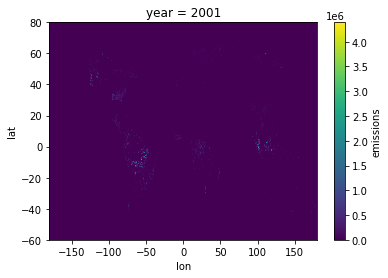

In [44]:
coarsened_sel.emissions.plot()

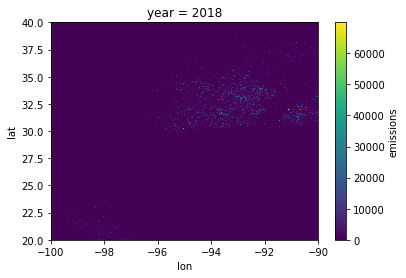

In [20]:
combined_ds.isel(year=17).emissions.plot()

In [49]:
diff = combined_ds_testing.sel(year=2005) - combined_ds.sel(year=2005).sel(lat=combined_ds_testing.lat,
                            lon=combined_ds_testing.lon)

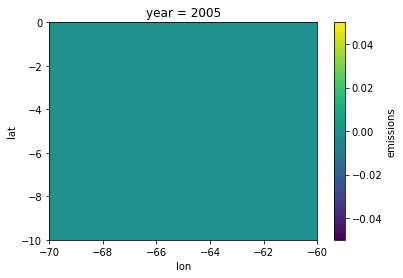

In [53]:
diff.emissions.plot()

In [55]:
combined_ds = combined_ds.rename({'emissions': 'Emissions [tC02/year]'})

Then we'll load all of these back into a single array and concatenate along the year dimension.

# Sanity checks!

Let's take a look at the dataset and get a handle on whether this makes sense. Let's do it by looking at a handful of big fires as a gut check for biomass loss.

First let's check out the Thomas Fire in Santa Barbara in 2017, the second largest (outside of 2020) California history
since we don't have 2020 data yet. This ranking is according to wikipedia - https://en.wikipedia.org/wiki/List_of_California_wildfires. I include this because there's a narrative here - we're on a Sherlock Holmes level hunt for fires. Using satellite biomass data as our clues!

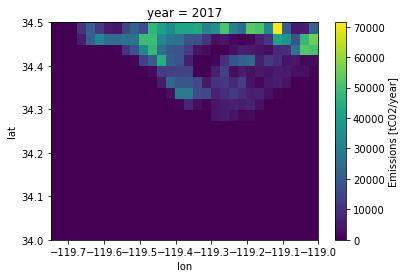

In [56]:
santa_barbara = combined_ds.sel(lat=slice(34,34.5), lon=slice(-119.75, -119))['Emissions [tC02/year]']
santa_barbara.sel(year=2017).plot()

But then let's see how that fire compared to years previous. It turns out that, indeed, it was a big one, burning over 40 megatons of biomass in 2017. Some of that fire carried over into 2018 too.

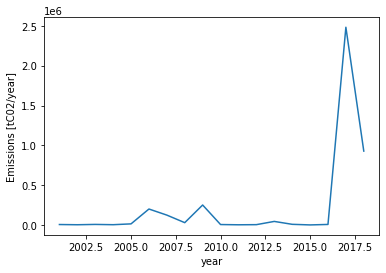

In [57]:
santa_barbara.sum(dim=['lat', 'lon']).plot()

Out of curiosity, we can take a look at a slightly bigger box, extending further north. When we do that, we notice that the 2017 Thomas Fire was actually dwarfed by something in 2007. What is this aberration!? I thought wikipedia, the paragon of truth, told us that the Thomas Fire was the biggest!

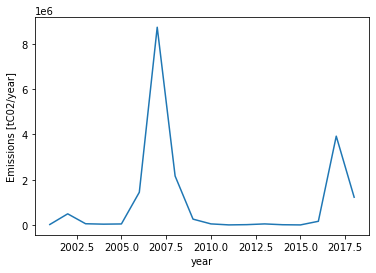

In [59]:
santa_barbara_bigger = combined_ds.sel(lat=slice(34,35), lon=slice(-119.75, -119))['Emissions [tC02/year]']
santa_barbara_bigger.sum(dim=['lat', 'lon']).plot()

Turns out that actually there was *giant* complex of fires (also in Santa Barbara county) in 2007. Over a million acres burned. And they were picked up by the loss in biomass. So this is some rejection of bias on my end! Excellent. 

Let's go check somewhere else just to see if it's working elsewhere. Let's travel up to my home state of Washington State. As a gut check, the 2015 fire season was the largest in recent memory. Let's see if it jumps out at all in total Washington losses.

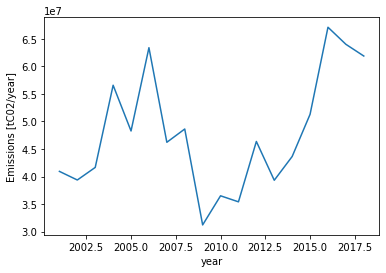

In [60]:
washington_state = combined_ds.sel(lat=slice(45.5,49), lon=slice(-124.6, -117))['Emissions [tC02/year]']
washington_state.sum(dim=['lat', 'lon']).plot()

Well, let's take a look at the Okanaogan region where they had a giant fire in 2015. So, let's see if zooming in a little further into specific regions of big fires leap out. 

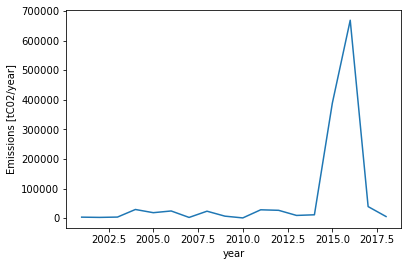

In [61]:
washington_state.sel(lat=slice(48.4,48.6), lon=slice(-119.8, -119.6)).sum(dim=['lat', 'lon']).plot()

Now let's check out Brazil. First we can look at the state of Mato Grosso, one site of heavy deforestation for conversion to agriculure.

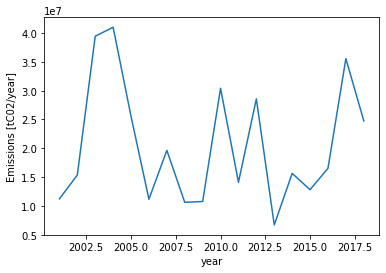

In [62]:
combined_ds.sel(lat=slice(-14, -11), lon=slice(-55,-54)).sum(dim=['lat', 'lon'])['Emissions [tC02/year]'].plot()

Then we can switch to the state of Pará.

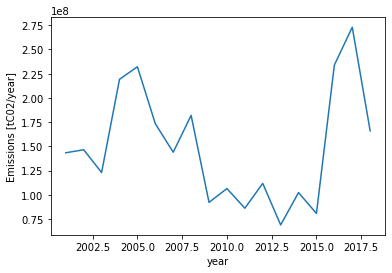

In [63]:
combined_ds.sel(lat=slice(-9, -2), lon=slice(-54,-49)).sum(dim=['lat', 'lon'])['Emissions [tC02/year]'].plot()

Selecting a year we can see individual plots of land where mass deforestation has occurred.

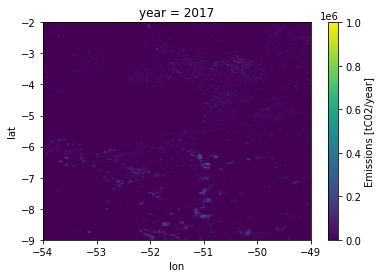

In [64]:
combined_ds.sel(lat=slice(-9, -2), lon=slice(-54,-49)).sel(year=2017)['Emissions [tC02/year]'].plot(vmax=1e6)

# Gutcheck by trying to reproduce Zarin et al (2016)
## a.k.a. Reproducibility Rumble

Now let's try to reproduce a figure from Zarin et al (2016). We'll try out Mexico since we can reasonably easily select a box around all of Mexico without including other countries. We include Guatemala and a bit of Southern Texas/Arizona but let's just assume those are negligible compared to the country of Mexico. So, comparing this to the plot from 

In [62]:
mexico = combined_ds.sel(lat=slice(14,31), lon=slice(-117,-87))

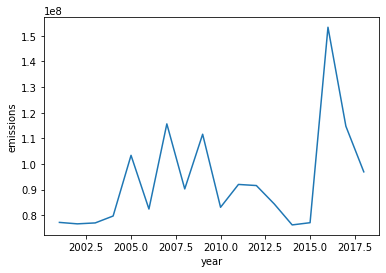

In [64]:
mexico.sum(dim=['lat', 'lon'])['emissions'].plot()

SAD FACE! We're off by a _ton_ <--- a pun! because we're talking about tons of carbon!! :grin:

our estimates are off by a factor of ~100. now, zarin's plot for mexico only includes deforestation, (so maybe that excludes the fire-attributed losses?). But they're def off by orders of magnitude. maybe these estimates we're calculating by combining everything is actually spatially-averaged quantities - tCO2/hectare. which would mean that an average is really what we want. and that coarsening isn't quite right because the geographic transformation matters. nevertheless, i think the coarsening effect might be okay as an approximation for now.

HOWEVER, the per hectare unit thing is an issue- we summed things to go from 30m-->3km, so we'd need to divide them by ~10000 (to account for the coarsening 100-fold in each direction) to get back to the per hectare unit. and then we use that per hectare unit and average it across regions and multiply by the hectare area to get the right tCO2. as a gut check i applied that "divide by 10,000" correction that around my bounding box for mexico, multiplied it by mexico's area (in hectares) and the units are on the same order of magnitude of zarin. now, this is very back-of-the-envelope. but i think it makes sense! so, for reporting values, each of our coarsened pixels just needs to be divided by 10,000 and then scaled by how many hectares that pixel is (which decreases going away from the equator, but we could make a raster of that).

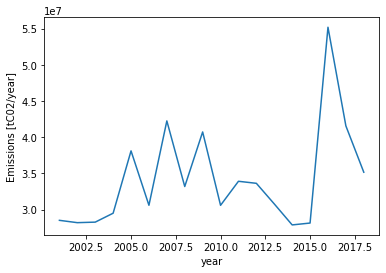

In [109]:
hectares_in_mexico = 197253494
correction_for_having_summed_during_coarsening = 100 * 100
(mexico.mean(dim=['lat', 'lon'])*hectares_in_mexico/correction_for_having_summed_during_coarsening)['Emissions [tC02/year]'].plot()

ba da bing ba da boom! Now we're in the ballpark of Zarin. Don't miss the next episode, when we figure out why our wiggles are totally off from theirs.... tune in!

In [ ]:
client.close()
cluster.close()

In [15]:
print('here!')

here!
